In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

import warnings 
warnings.filterwarnings("ignore")

%config InlineBackend.figure_format = 'retina'

# 1. Loading Data

In [2]:
submission_df = pd.read_csv('/kaggle/input/playground-series-s3e26/sample_submission.csv')
print(submission_df.shape)
submission_df.head(2)

(5271, 4)


,id,Status_C,Status_CL,Status_D
0,7905,0.628084,0.034788,0.337128
1,7906,0.628084,0.034788,0.337128


In [3]:
test_df = pd.read_csv('/kaggle/input/playground-series-s3e26/test.csv')
print(test_df.shape)
test_df.head(2)

(5271, 19)


,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,7905,3839,D-penicillamine,19724,F,N,Y,N,N,1.2,546.0,3.37,65.0,1636.0,151.9,90.0,430.0,10.6,2.0
1,7906,2468,D-penicillamine,14975,F,N,N,N,N,1.1,660.0,4.22,94.0,1257.0,151.9,155.0,227.0,10.0,2.0


In [4]:
train_df = pd.read_csv('/kaggle/input/playground-series-s3e26/train.csv')
print(train_df.shape)
train_df.head(2)

(7905, 20)


,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C


In [5]:
train_df.info()

# no null data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7905 non-null   int64  
 1   N_Days         7905 non-null   int64  
 2   Drug           7905 non-null   object 
 3   Age            7905 non-null   int64  
 4   Sex            7905 non-null   object 
 5   Ascites        7905 non-null   object 
 6   Hepatomegaly   7905 non-null   object 
 7   Spiders        7905 non-null   object 
 8   Edema          7905 non-null   object 
 9   Bilirubin      7905 non-null   float64
 10  Cholesterol    7905 non-null   float64
 11  Albumin        7905 non-null   float64
 12  Copper         7905 non-null   float64
 13  Alk_Phos       7905 non-null   float64
 14  SGOT           7905 non-null   float64
 15  Tryglicerides  7905 non-null   float64
 16  Platelets      7905 non-null   float64
 17  Prothrombin    7905 non-null   float64
 18  Stage   

In [6]:
test_df.isna().sum().sum()

# no null data

0

In [7]:
train_df['Status'].value_counts()

# unbalanced target data

Status
C     4965
D     2665
CL     275
Name: count, dtype: int64

# 2. column description
- N_Days : survival days (registration ~ death)
- Drug : D-penicillamine, Placebo
- Age : days
- Sex : F, M 
- Ascites : 복수 N, Y
- Hepatomegaly : 간비대 N, Y
- Spiders : 모세혈관이 확장되어 붉은 거미의 다리와 같이 보이는 것 N, Y
- Edema : 부종 N(No edema), S(edema resolved by diluretics), Y(edema despite diluretics therapy) 
- Bilirubin : 혈청 빌리루빈
- Cholesterol :
- Albumin :
- Copper :
- Alk_Phos :
- SGOT : 
- Tryglicerides : 
- Platelets : 혈소
- Prothrombin : time 혈액이 얼마나 빨리 굳는지를 초 단위 시간으로 측정한 값
- Stage : histologic stage of disease
- (Survival) Status : D (death), C (censored), CL (censored due to liver transplantation)
- source https://www.kaggle.com/datasets/joebeachcapital/cirrhosis-patient-survival-prediction

# 3. data transformation: yeo-johnson and OneHotEncoding

In [8]:
train = train_df.drop(['id', 'Status'], axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         7905 non-null   int64  
 1   Drug           7905 non-null   object 
 2   Age            7905 non-null   int64  
 3   Sex            7905 non-null   object 
 4   Ascites        7905 non-null   object 
 5   Hepatomegaly   7905 non-null   object 
 6   Spiders        7905 non-null   object 
 7   Edema          7905 non-null   object 
 8   Bilirubin      7905 non-null   float64
 9   Cholesterol    7905 non-null   float64
 10  Albumin        7905 non-null   float64
 11  Copper         7905 non-null   float64
 12  Alk_Phos       7905 non-null   float64
 13  SGOT           7905 non-null   float64
 14  Tryglicerides  7905 non-null   float64
 15  Platelets      7905 non-null   float64
 16  Prothrombin    7905 non-null   float64
 17  Stage          7905 non-null   float64
dtypes: float

In [9]:
test = test_df.drop(['id'], axis=1)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 0 to 5270
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         5271 non-null   int64  
 1   Drug           5271 non-null   object 
 2   Age            5271 non-null   int64  
 3   Sex            5271 non-null   object 
 4   Ascites        5271 non-null   object 
 5   Hepatomegaly   5271 non-null   object 
 6   Spiders        5271 non-null   object 
 7   Edema          5271 non-null   object 
 8   Bilirubin      5271 non-null   float64
 9   Cholesterol    5271 non-null   float64
 10  Albumin        5271 non-null   float64
 11  Copper         5271 non-null   float64
 12  Alk_Phos       5271 non-null   float64
 13  SGOT           5271 non-null   float64
 14  Tryglicerides  5271 non-null   float64
 15  Platelets      5271 non-null   float64
 16  Prothrombin    5271 non-null   float64
 17  Stage          5271 non-null   float64
dtypes: float

In [10]:
# numeric variables in train data

train_num = train.select_dtypes(include=['int', 'float']).columns
train[train_num].head(2)

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,999,21532,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0
1,2574,19237,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0


In [11]:
# numeric variables in test data

test_num = test.select_dtypes(include=['int', 'float']).columns
test[test_num].head(2)

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,3839,19724,1.2,546.0,3.37,65.0,1636.0,151.9,90.0,430.0,10.6,2.0
1,2468,14975,1.1,660.0,4.22,94.0,1257.0,151.9,155.0,227.0,10.0,2.0


In [12]:
# yeo-johnson trnsformation 

from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
pt.fit(train[train_num])

train_num_pt = pt.transform(train[train_num])
train_num_pt = pd.DataFrame(train_num_pt, columns = train[train_num].columns)
train_num_pt.head(2)

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,-0.914653,0.863633,0.717416,0.124061,-0.635276,1.316134,0.420889,1.308370,-1.390037,1.411685,-1.446045,-0.14537
1,0.569410,0.258459,-0.484236,0.503971,-0.095100,0.021285,0.261888,0.604105,-0.443003,1.085364,0.649597,-0.14537


In [13]:
test_num_pt = pt.transform(test[test_num])
test_num_pt = pd.DataFrame(test_num_pt, columns = test[test_num].columns)
test_num_pt.head(2)

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1.508158,0.388355,-0.086678,1.380682,-0.580392,0.061686,0.452329,0.89581,-0.382381,1.755820,0.134120,-1.206382
1,0.483461,-0.917739,-0.205571,1.701809,2.200202,0.538268,0.045511,0.89581,0.974303,-0.380957,-0.841884,-1.206382


In [14]:
def orig_transf_plots(orig_df, orig_variable, transf_df, transf_variable):
    plt.figure(figsize = (12, 3))

    plt.subplot(1, 2, 1)
    skew = orig_df[orig_variable].skew()
    sns.histplot(orig_df[orig_variable], kde = True, stat = "density", 
                 label = 'Skew = %.3f' %(skew), bins = 30, color = 'r')
    plt.legend(loc = 'best')
    plt.title('Original Data Histogram')

    plt.subplot(1, 2, 2)
    skew = transf_df[transf_variable].skew()
    sns.histplot(transf_df[transf_variable], kde = True, stat = "density", 
                 label = 'Skew = %.3f' %(skew), bins = 30, color = 'r')
    plt.legend(loc = 'best')
    plt.title('Transformed Data Histogram')

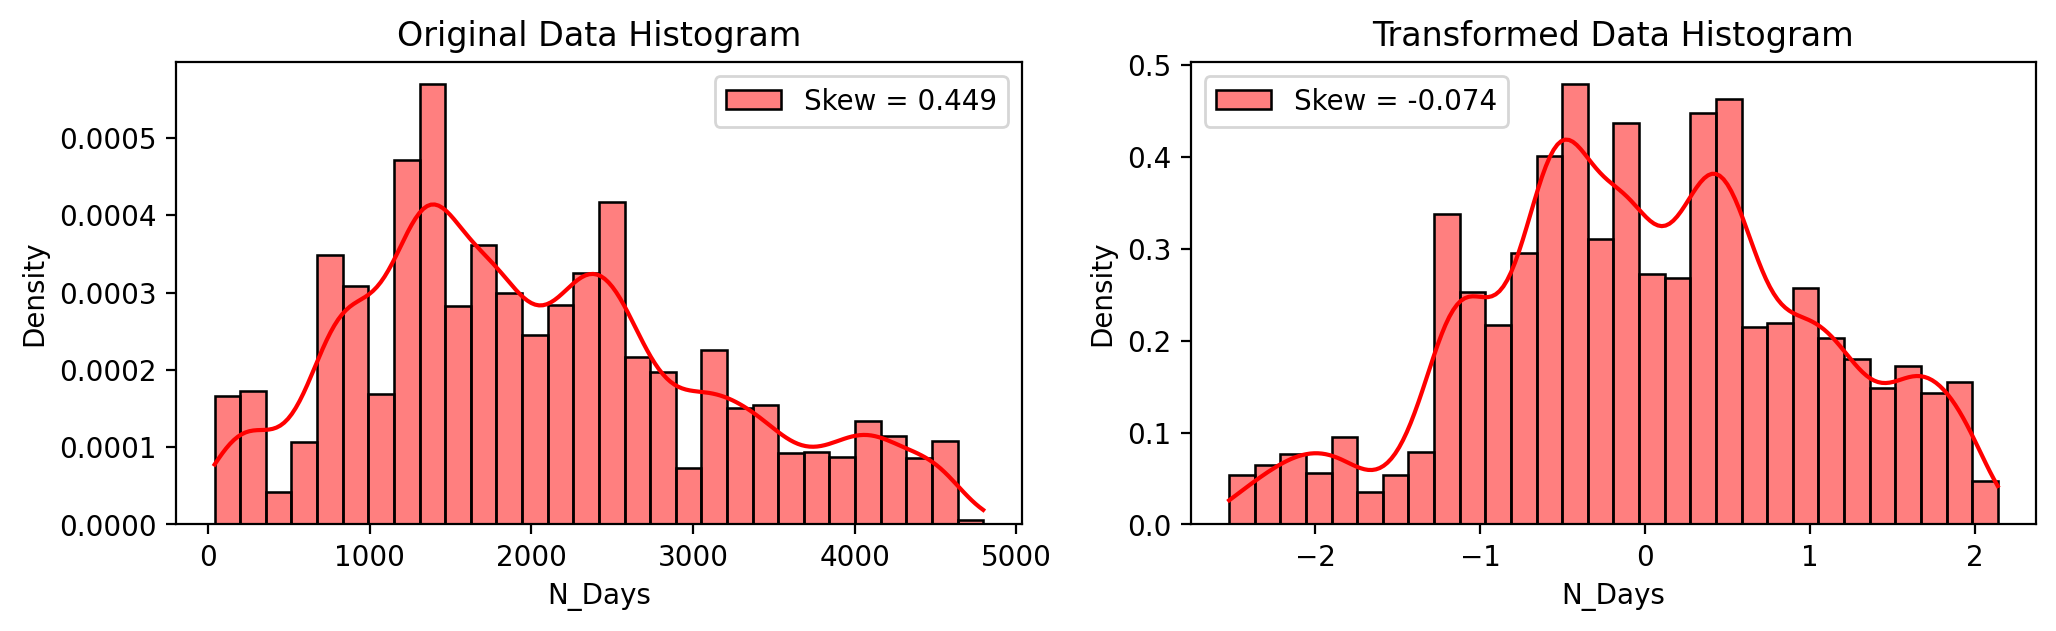

In [15]:
orig_transf_plots(train_df, 'N_Days', train_num_pt, 'N_Days')

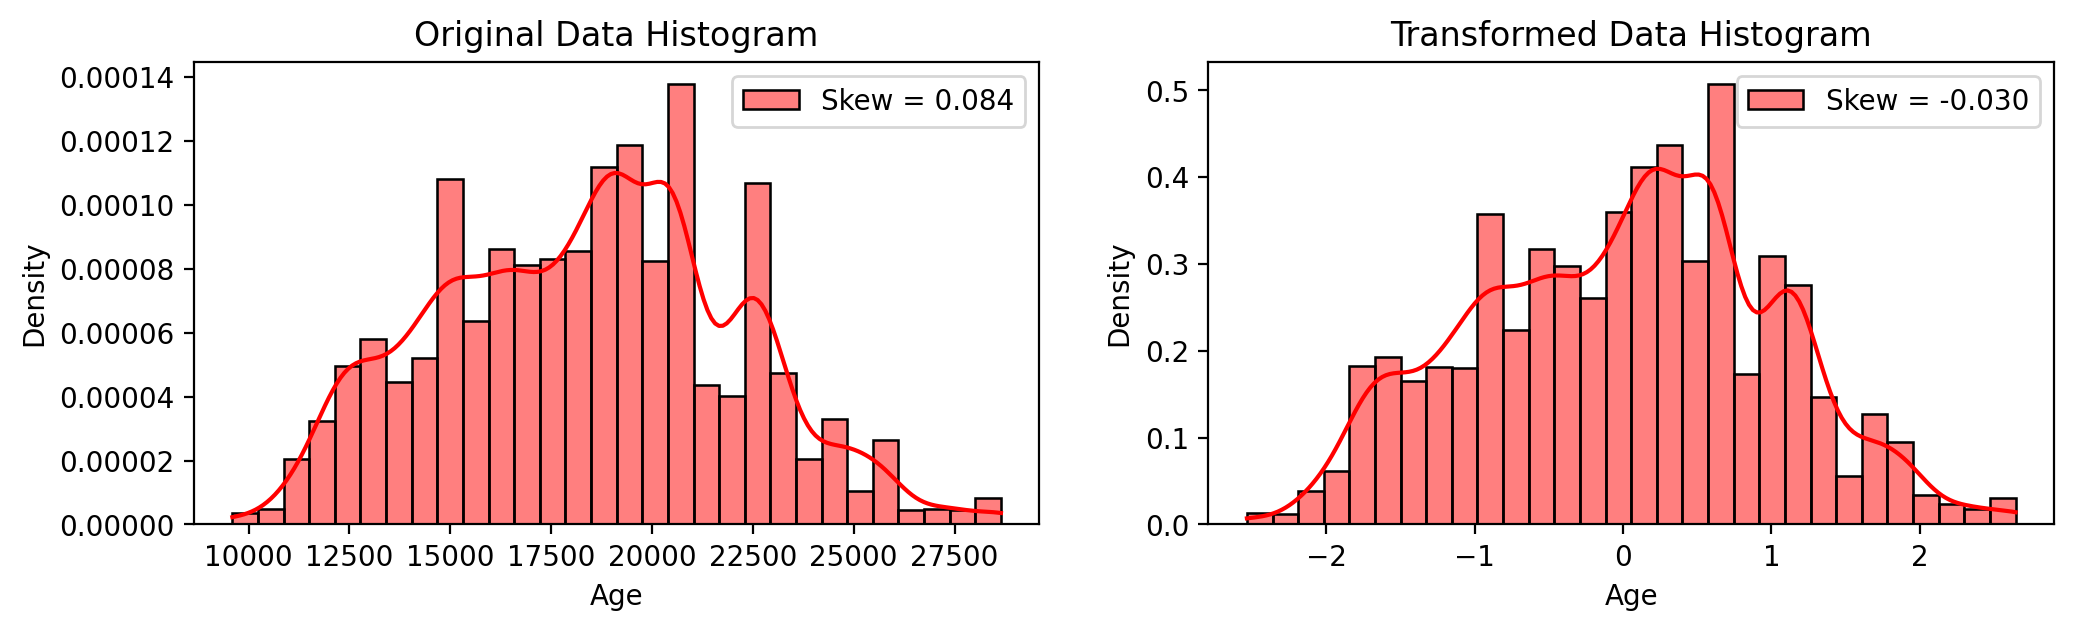

In [16]:
orig_transf_plots(train_df, 'Age', train_num_pt, 'Age')

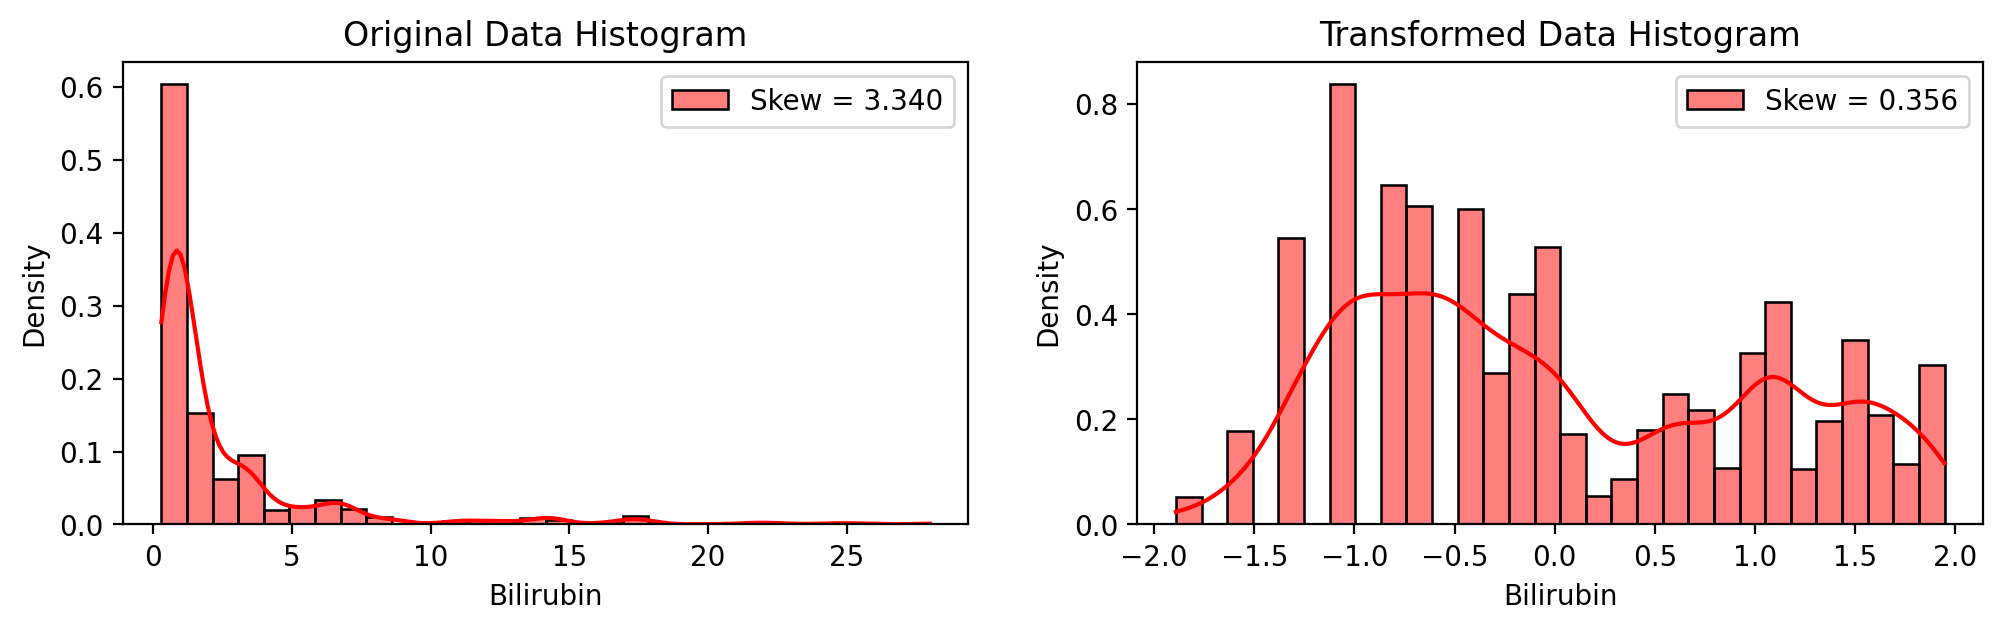

In [17]:
orig_transf_plots(train_df, 'Bilirubin', train_num_pt, 'Bilirubin')

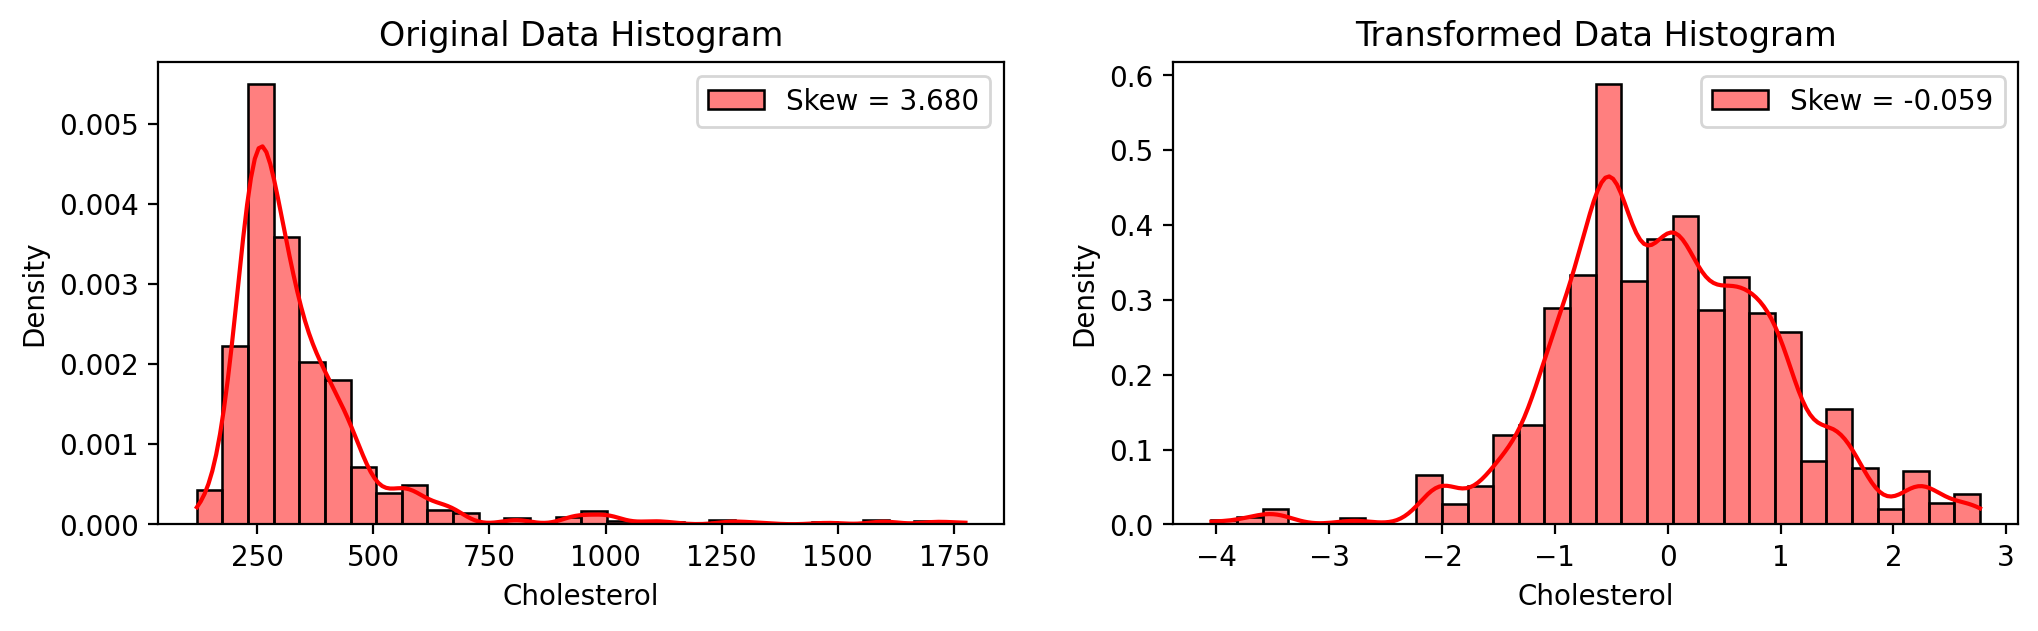

In [18]:
orig_transf_plots(train_df, 'Cholesterol', train_num_pt, 'Cholesterol')

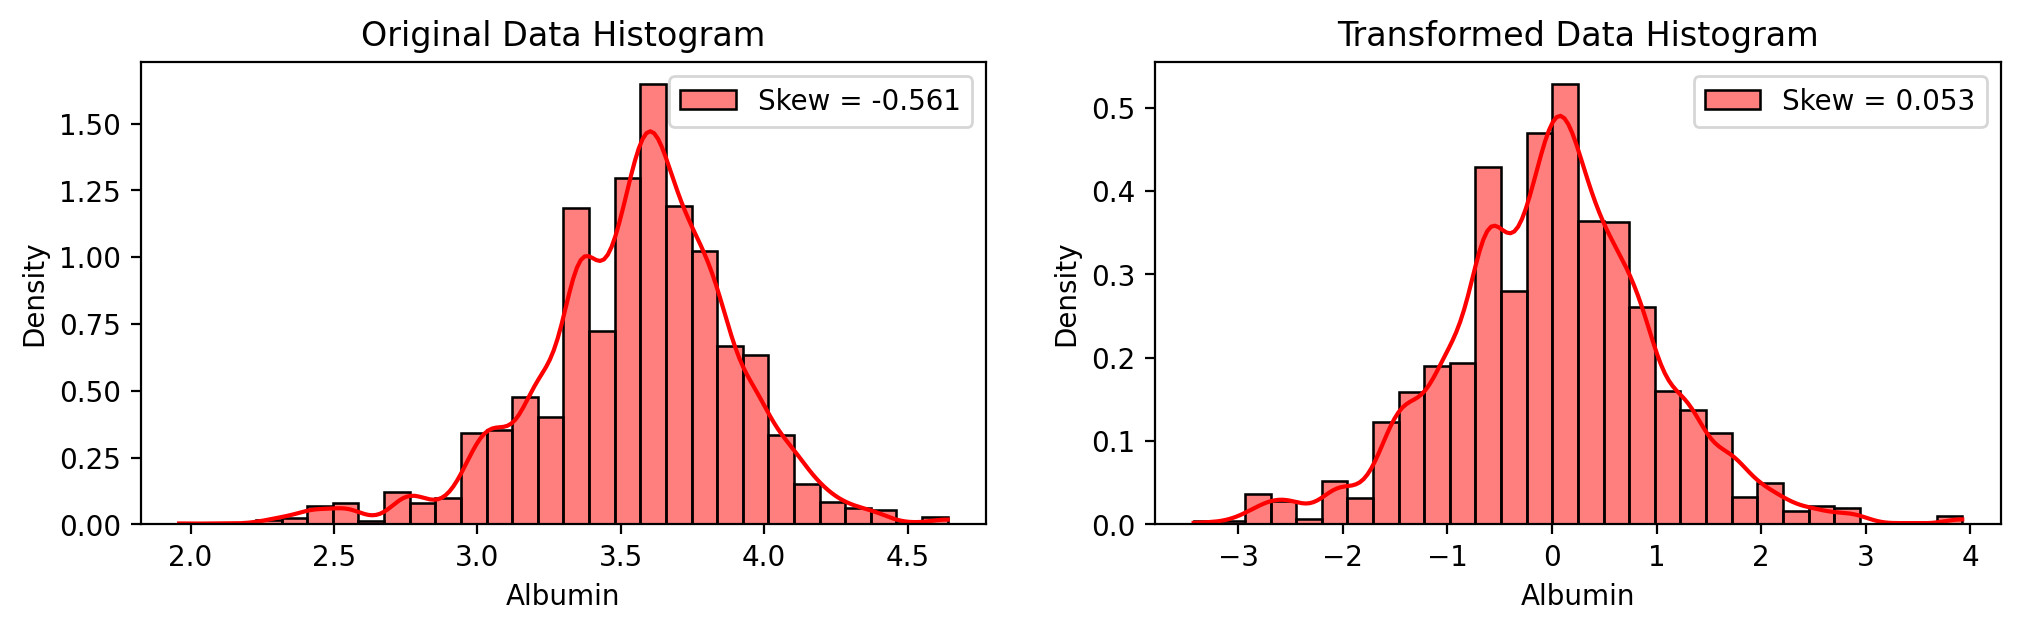

In [19]:
orig_transf_plots(train_df, 'Albumin', train_num_pt, 'Albumin')

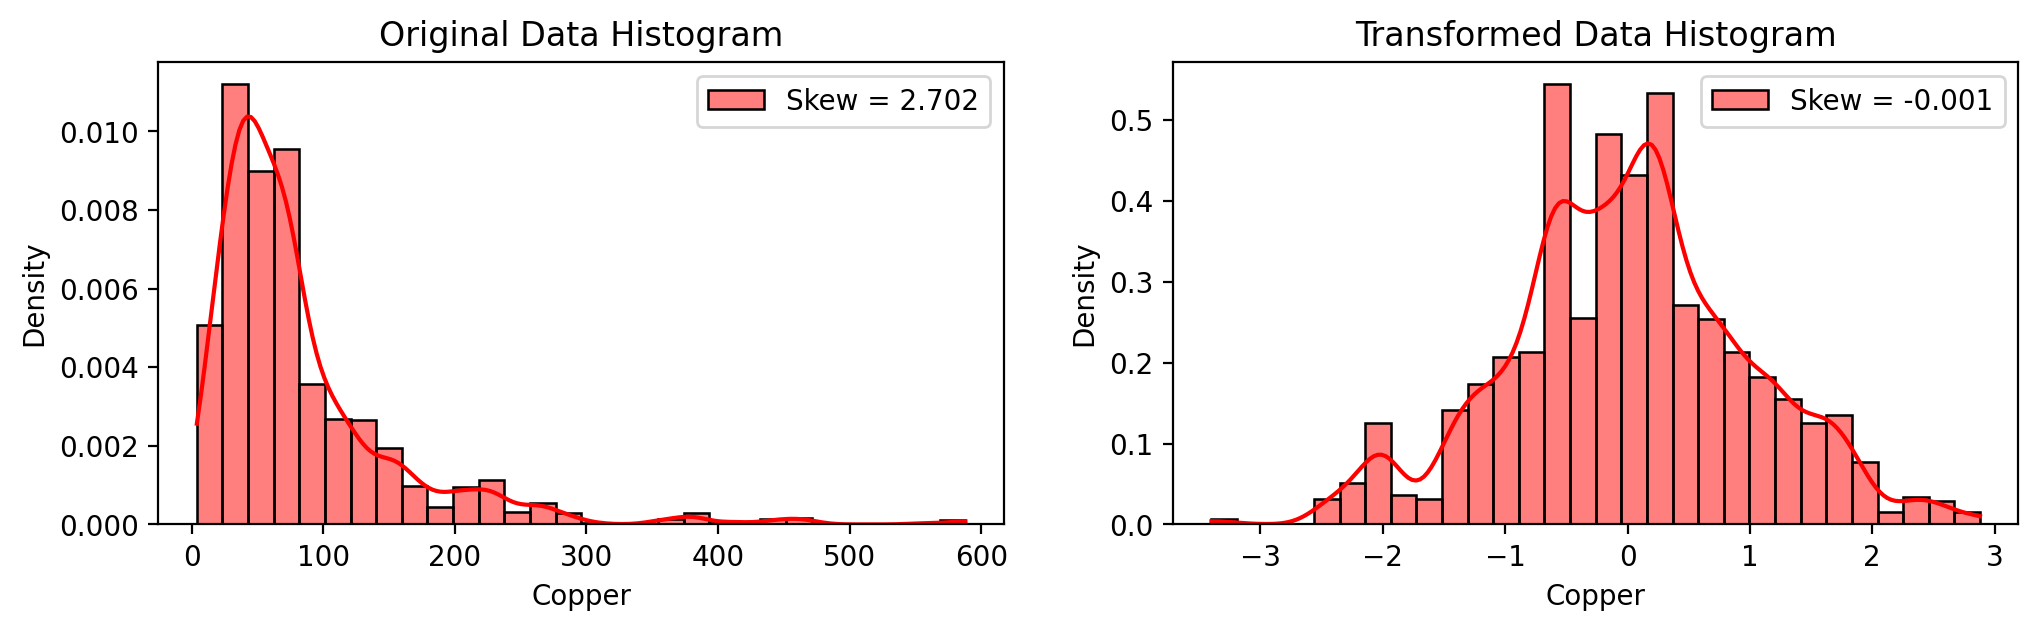

In [20]:
orig_transf_plots(train_df, 'Copper', train_num_pt, 'Copper')

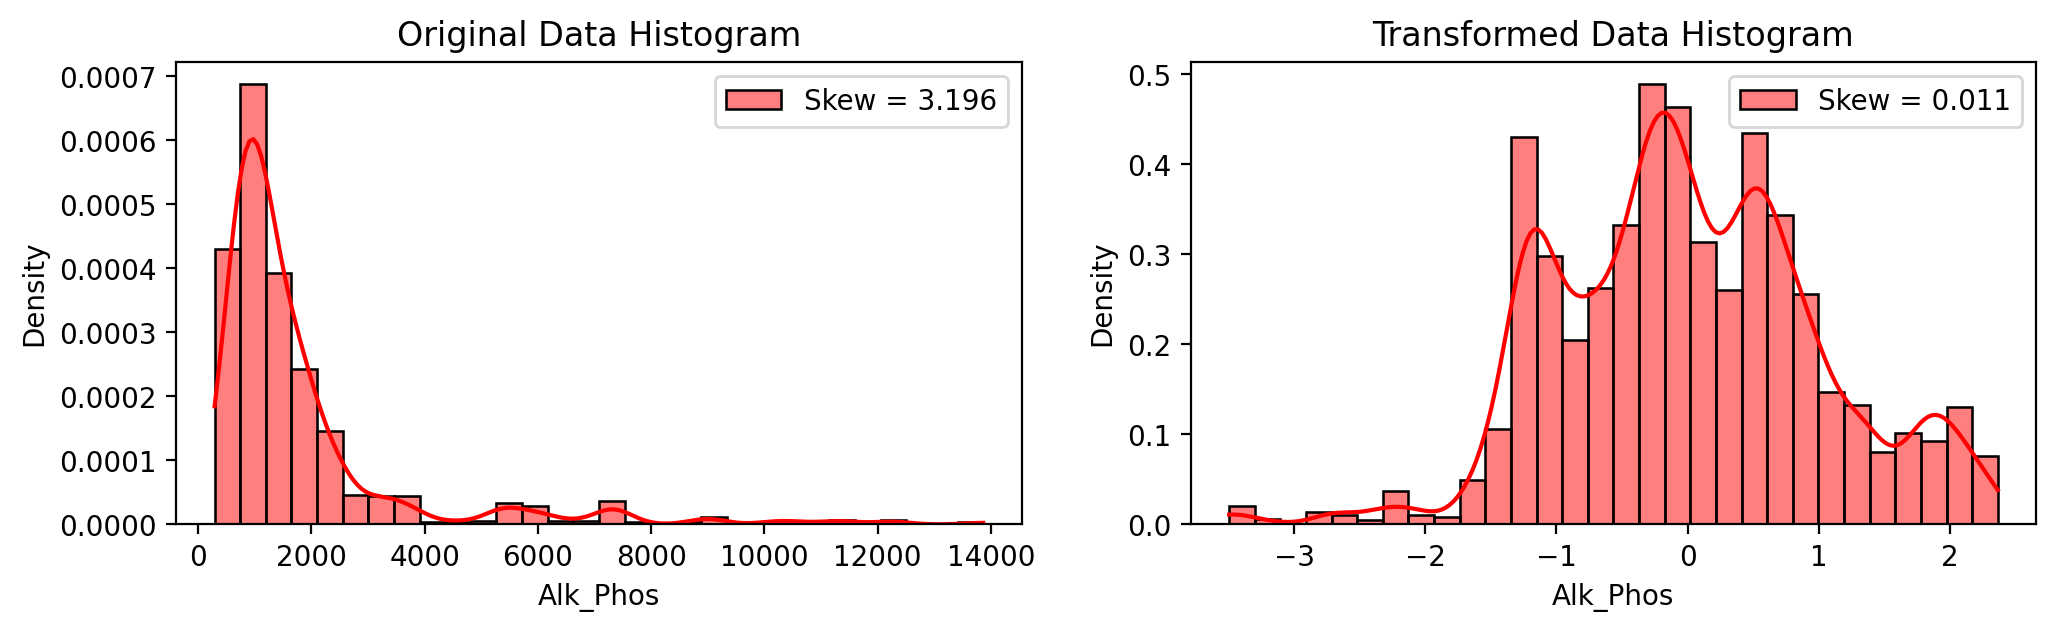

In [21]:
orig_transf_plots(train_df, 'Alk_Phos', train_num_pt, 'Alk_Phos')

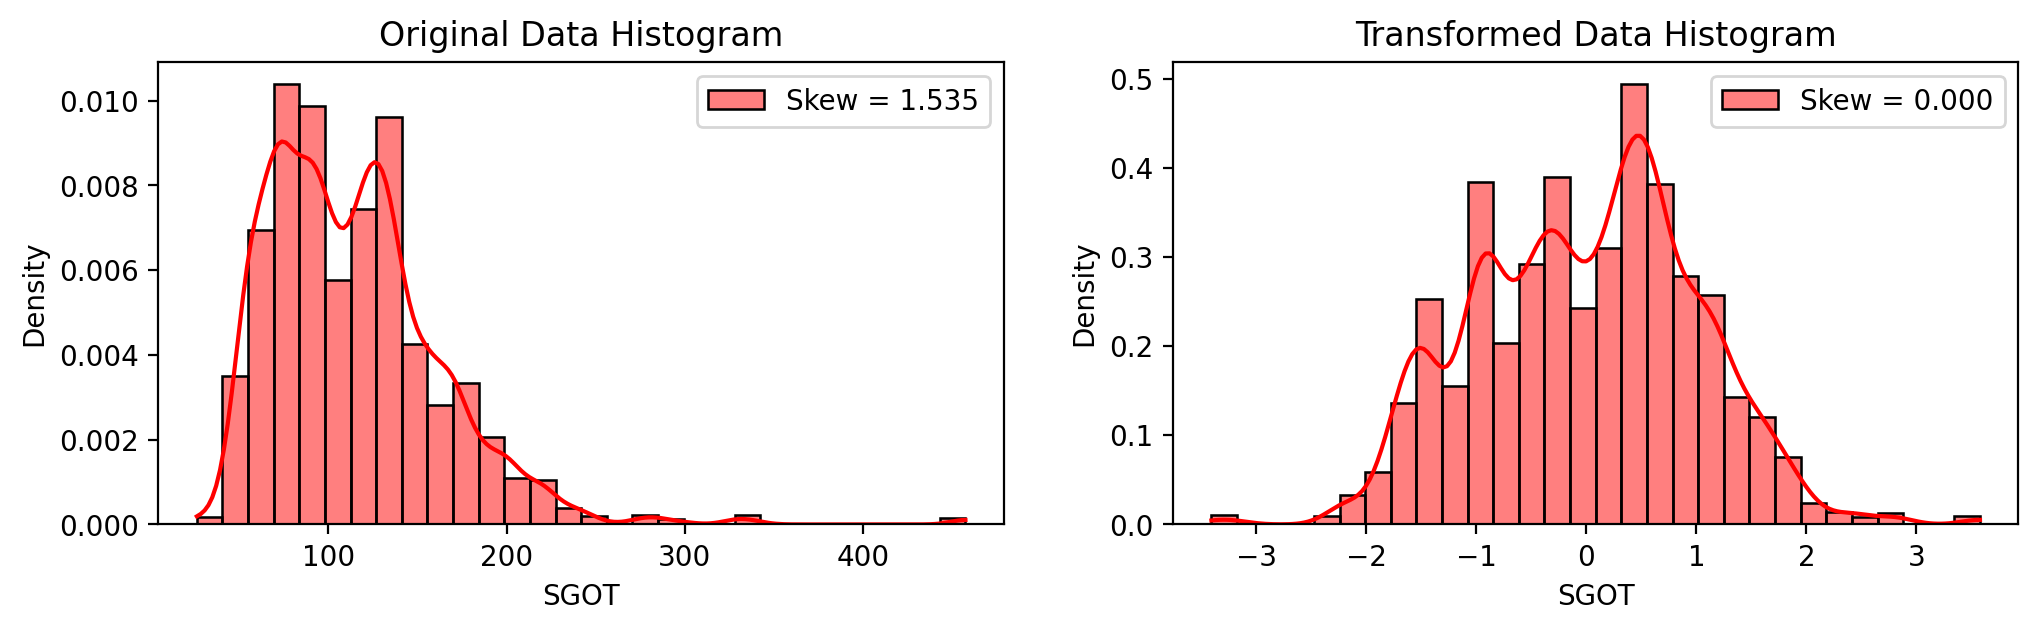

In [22]:
orig_transf_plots(train_df, 'SGOT', train_num_pt, 'SGOT')

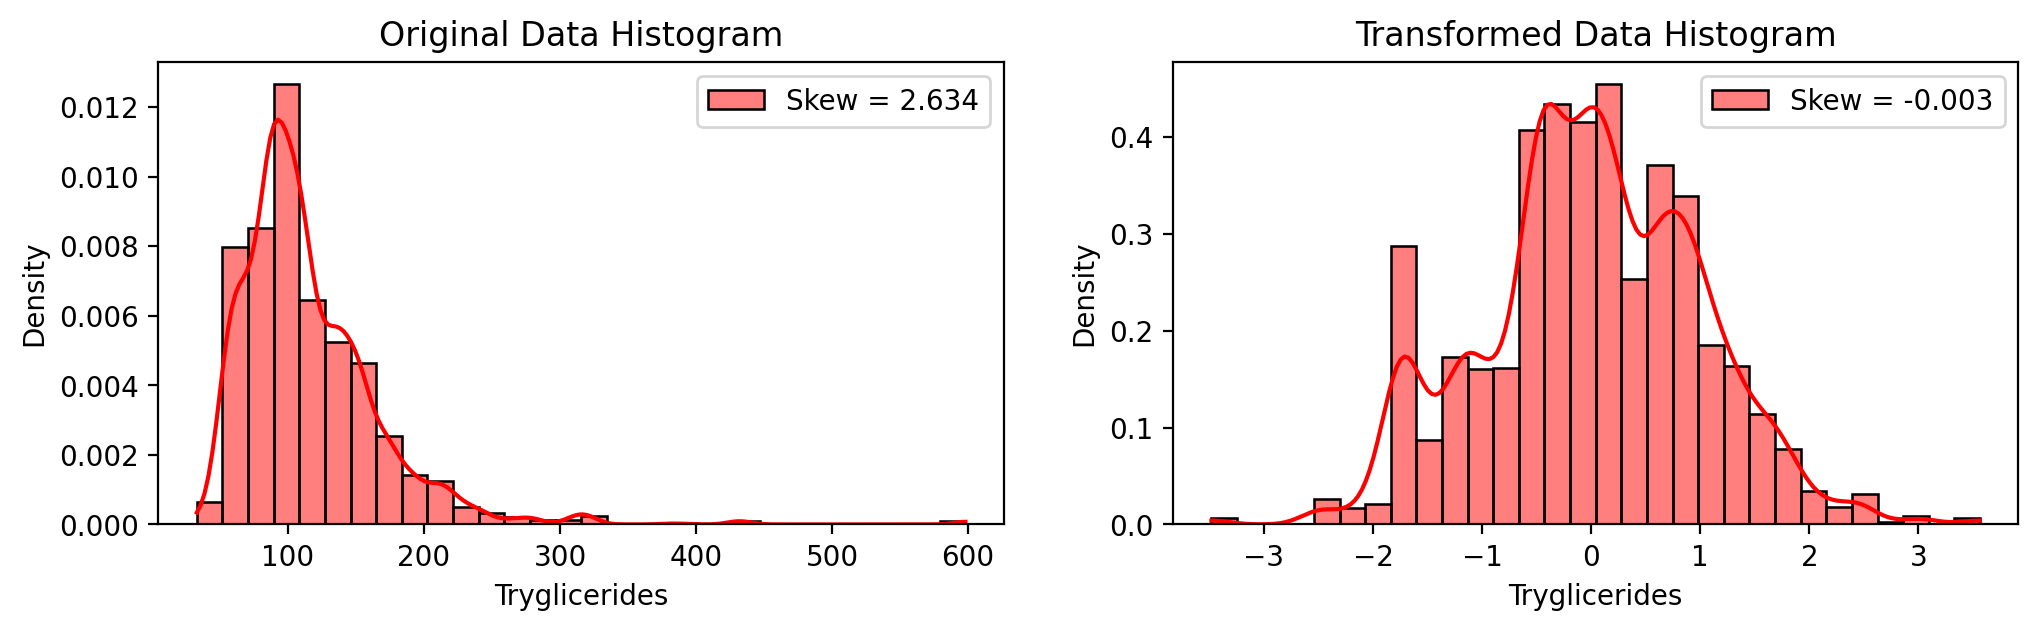

In [23]:
orig_transf_plots(train_df, 'Tryglicerides', train_num_pt, 'Tryglicerides')

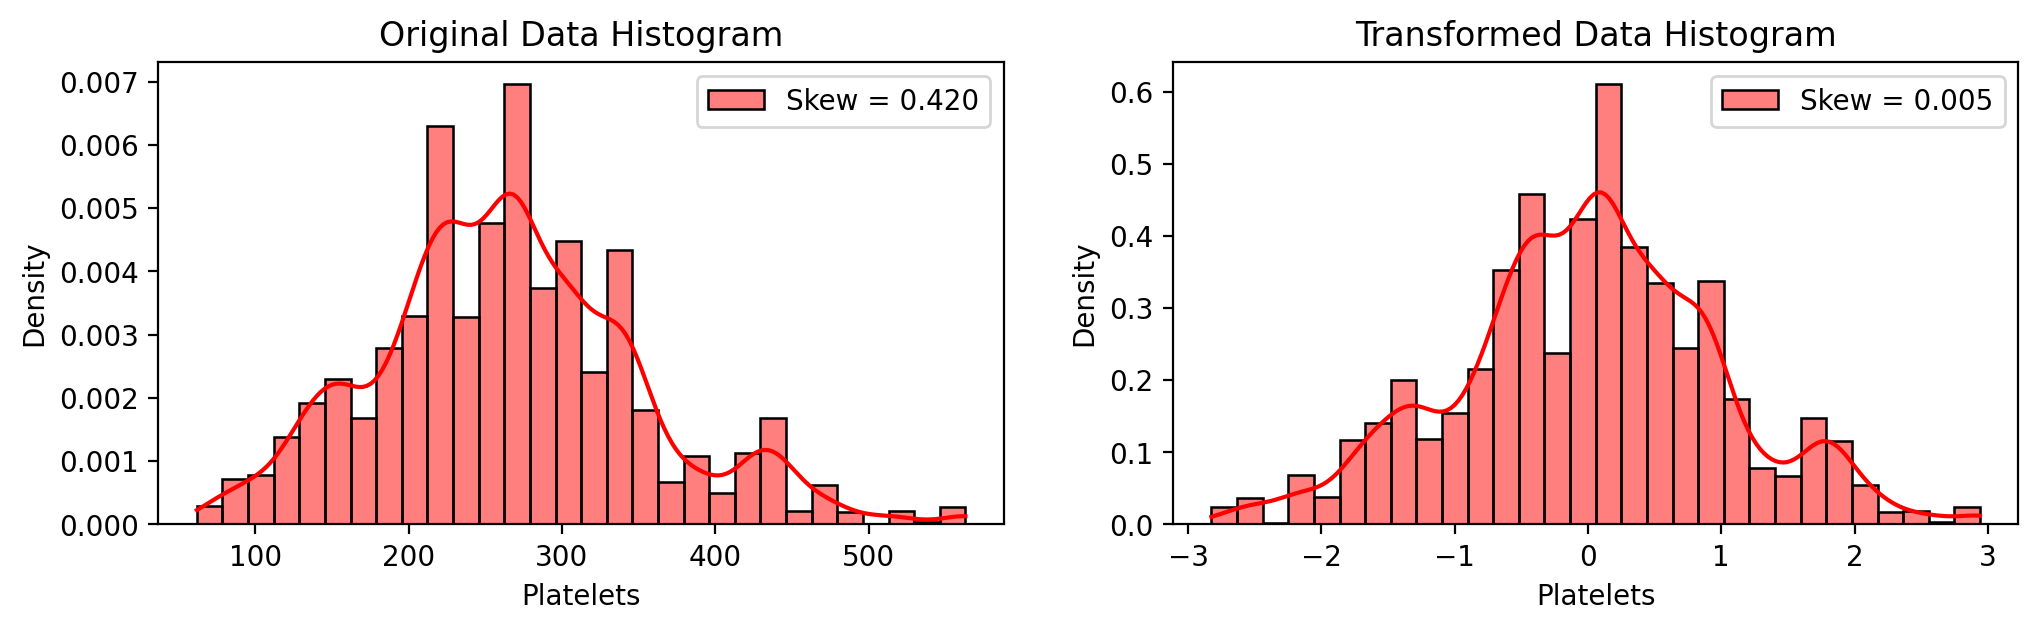

In [24]:
orig_transf_plots(train_df, 'Platelets', train_num_pt, 'Platelets')

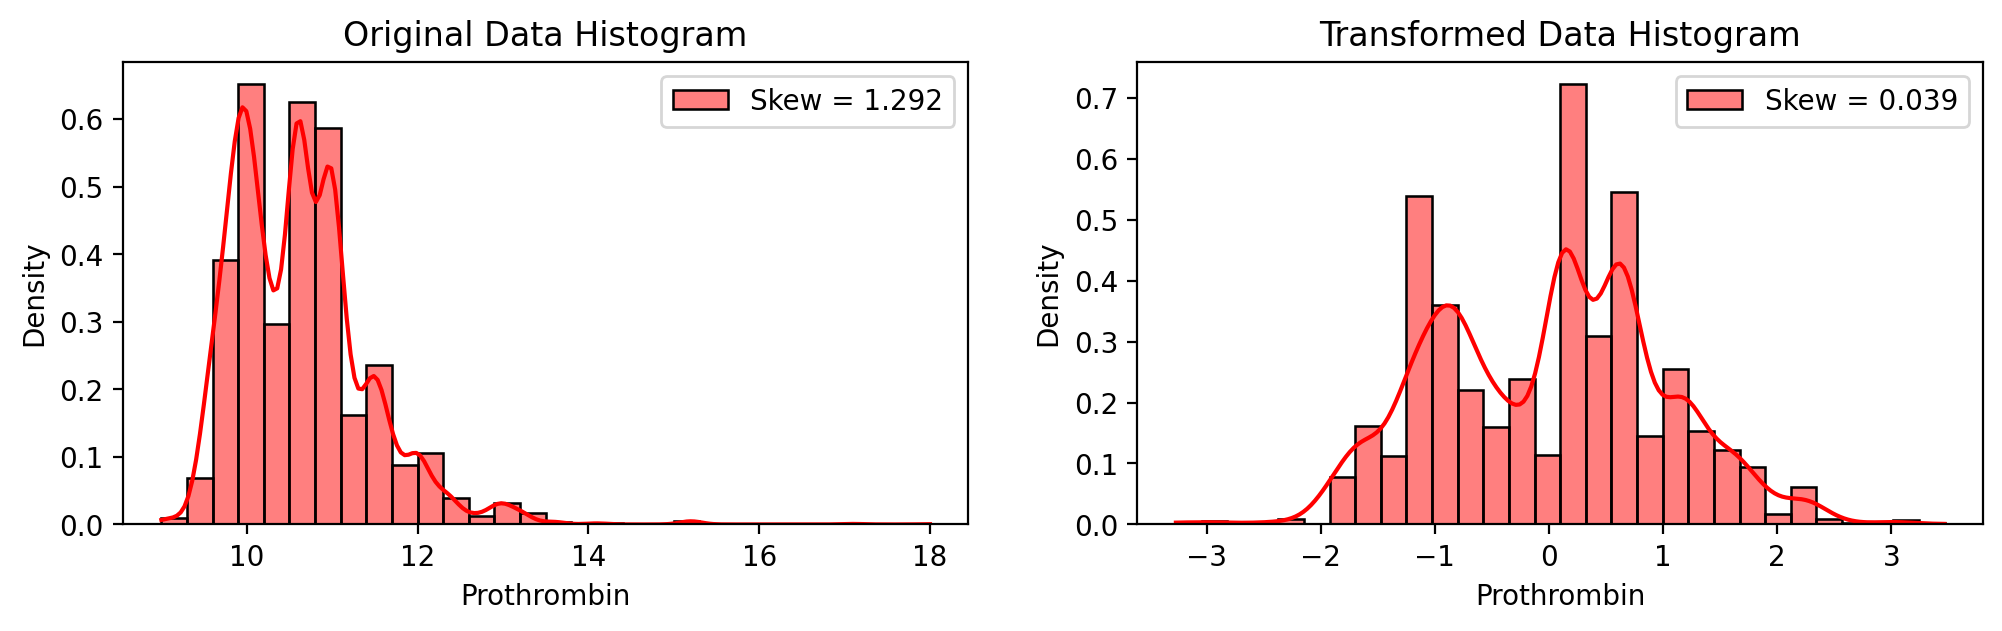

In [25]:
orig_transf_plots(train_df, 'Prothrombin', train_num_pt, 'Prothrombin')

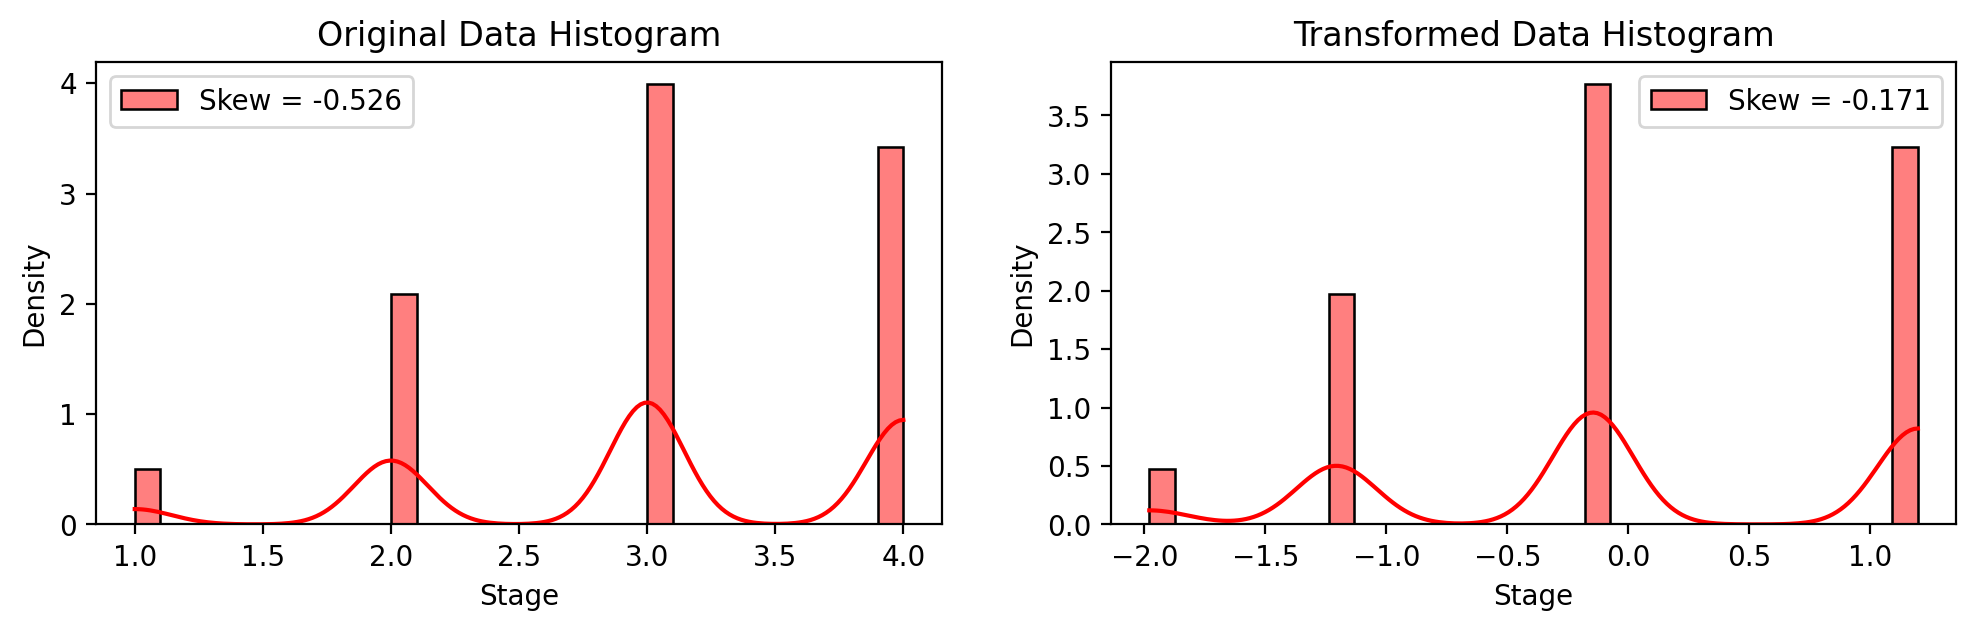

In [26]:
orig_transf_plots(train_df, 'Stage', train_num_pt, 'Stage')

In [27]:
# categoric variables in train data

train_cat = train.select_dtypes(include=['object']).columns
train_cat = train[train_cat]
train_cat.head()

,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema
0,D-penicillamine,M,N,N,N,N
1,Placebo,F,N,N,N,N
2,Placebo,F,N,Y,Y,Y
3,Placebo,F,N,N,N,N
4,Placebo,F,N,Y,N,N


In [28]:
# categoric variables in test data

test_cat = test.select_dtypes(include=['object']).columns
test_cat = test[test_cat]
test_cat.head()

,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema
0,D-penicillamine,F,N,Y,N,N
1,D-penicillamine,F,N,N,N,N
2,Placebo,F,N,Y,N,Y
3,D-penicillamine,F,N,N,N,N
4,D-penicillamine,F,N,Y,N,N


In [29]:
# OneHotEncoder

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse = False, categories = 'auto')
ohe.fit(train_cat)

columns = []
for i, c in enumerate(train_cat.columns):
    columns += [f'{c}_{v}' for v in ohe.categories_[i]]
    
train_cat_ohe = pd.DataFrame(ohe.transform(train_cat), columns = columns)
print(train_cat_ohe.shape)
train_cat_ohe.head()

(7905, 13)


,Drug_D-penicillamine,Drug_Placebo,Sex_F,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y
0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


In [30]:
test_cat_ohe = pd.DataFrame(ohe.transform(test_cat), columns = columns)
print(test_cat_ohe.shape)
test_cat_ohe.head()

(5271, 13)


,Drug_D-penicillamine,Drug_Placebo,Sex_F,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y
0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


In [31]:
# transformed data

train_tf = pd.concat([train_num_pt, train_cat_ohe], axis=1) 
test_tf = pd.concat([test_num_pt, test_cat_ohe], axis=1) 
train_tf.shape, test_tf.shape

((7905, 25), (5271, 25))

# 4. EDA

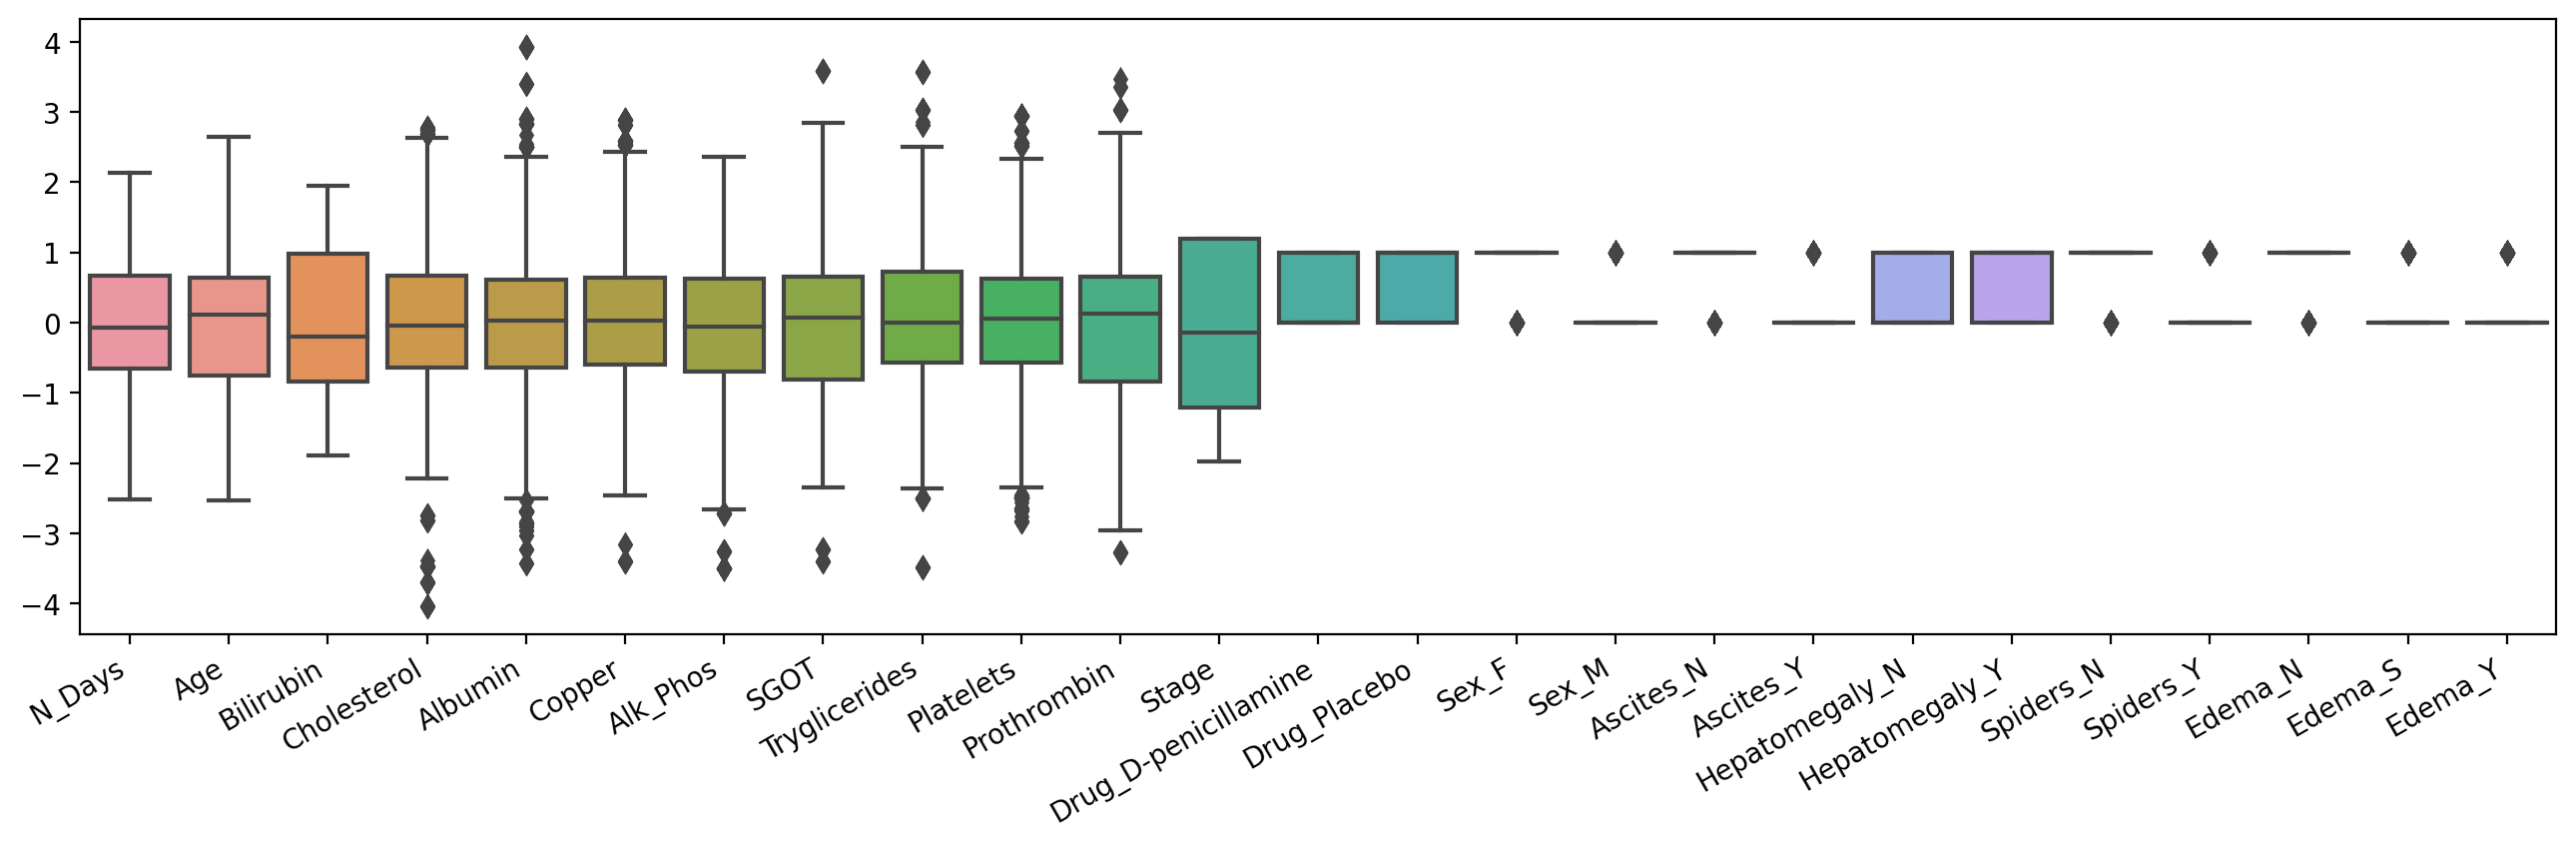

In [32]:
plt.figure(figsize=(16, 4))
plt.xticks(rotation=30, ha='right')
sns.boxplot(data = train_tf)
plt.show()

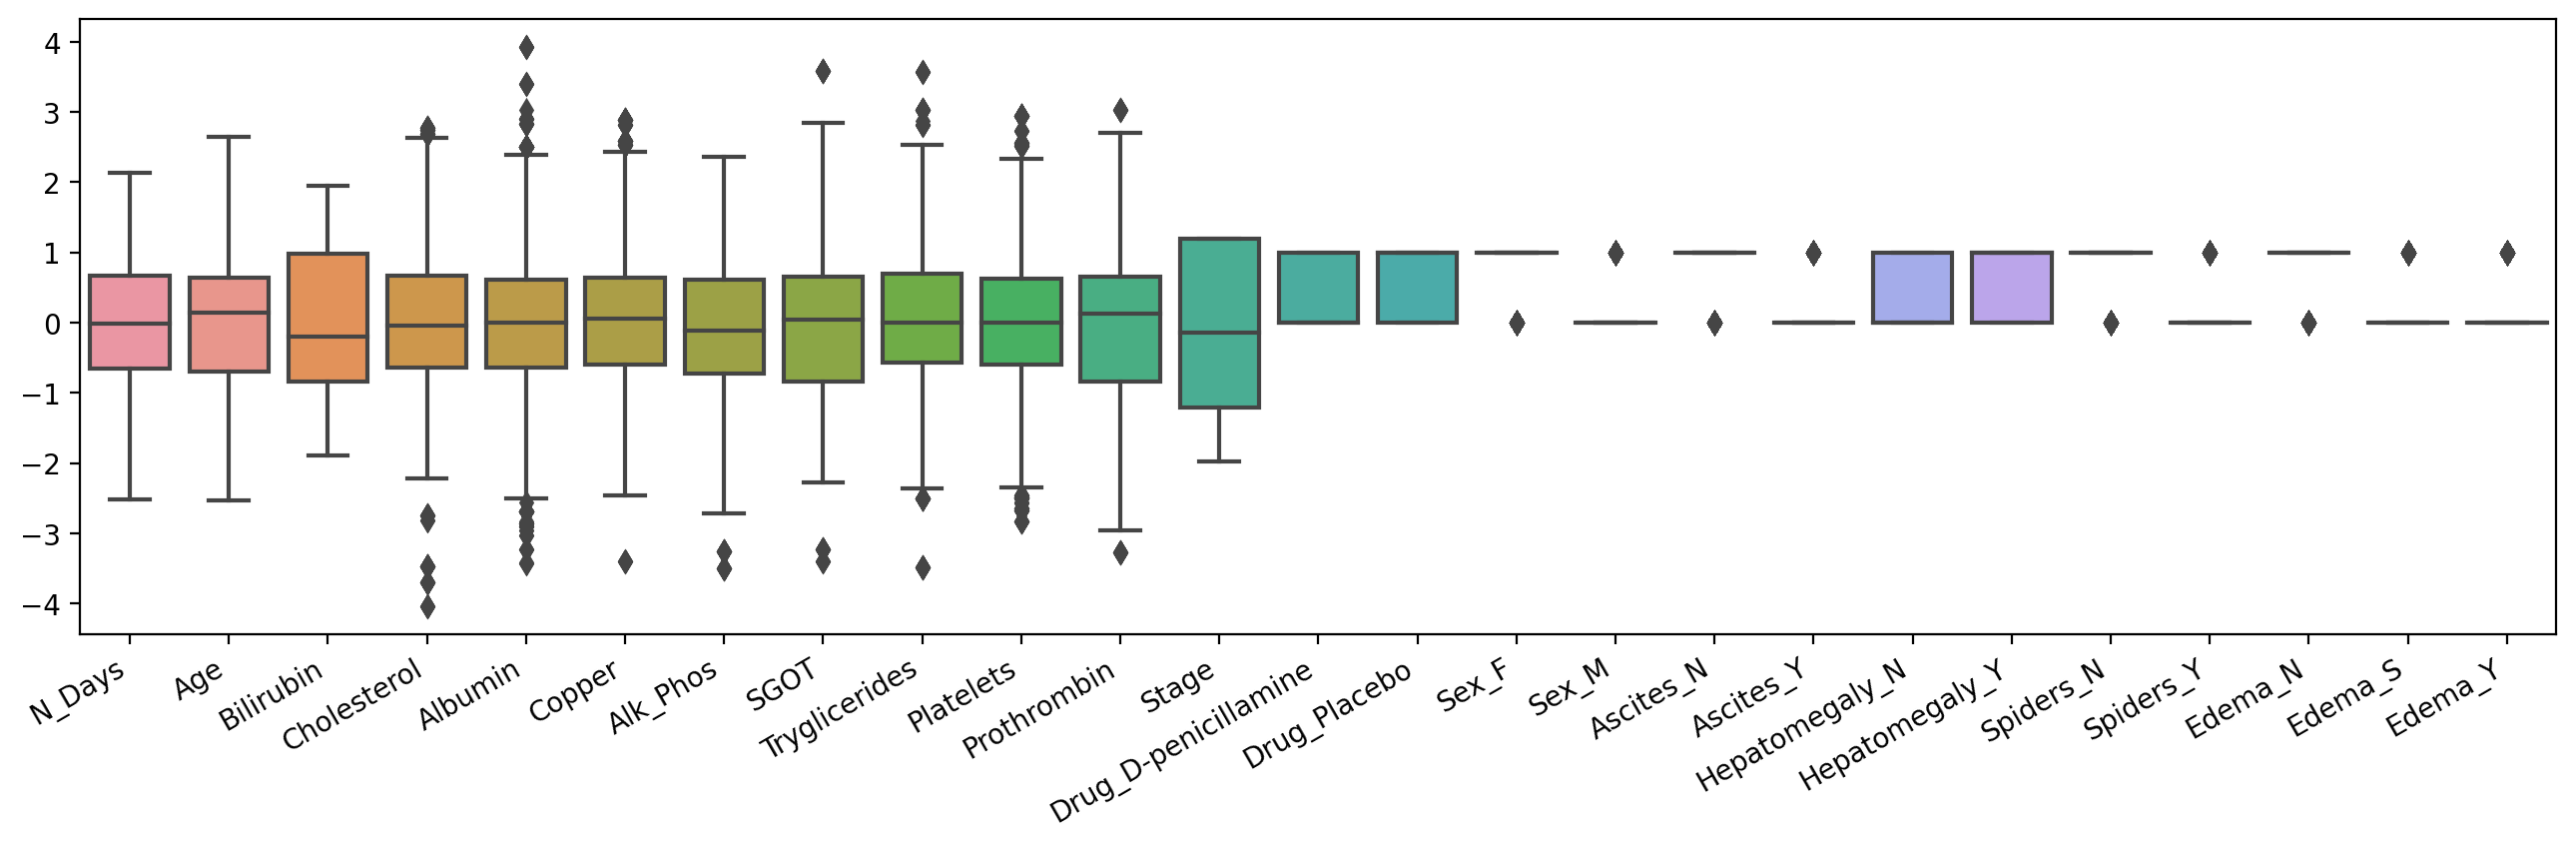

In [33]:
plt.figure(figsize=(16, 4))
plt.xticks(rotation=30, ha='right')
sns.boxplot(data = test_tf)
plt.show()

In [34]:
C = train_df[train_df['Status'] == 'C']
CL = train_df[train_df['Status'] == 'CL']
D = train_df[train_df['Status'] == 'D']
C.head(2)

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C


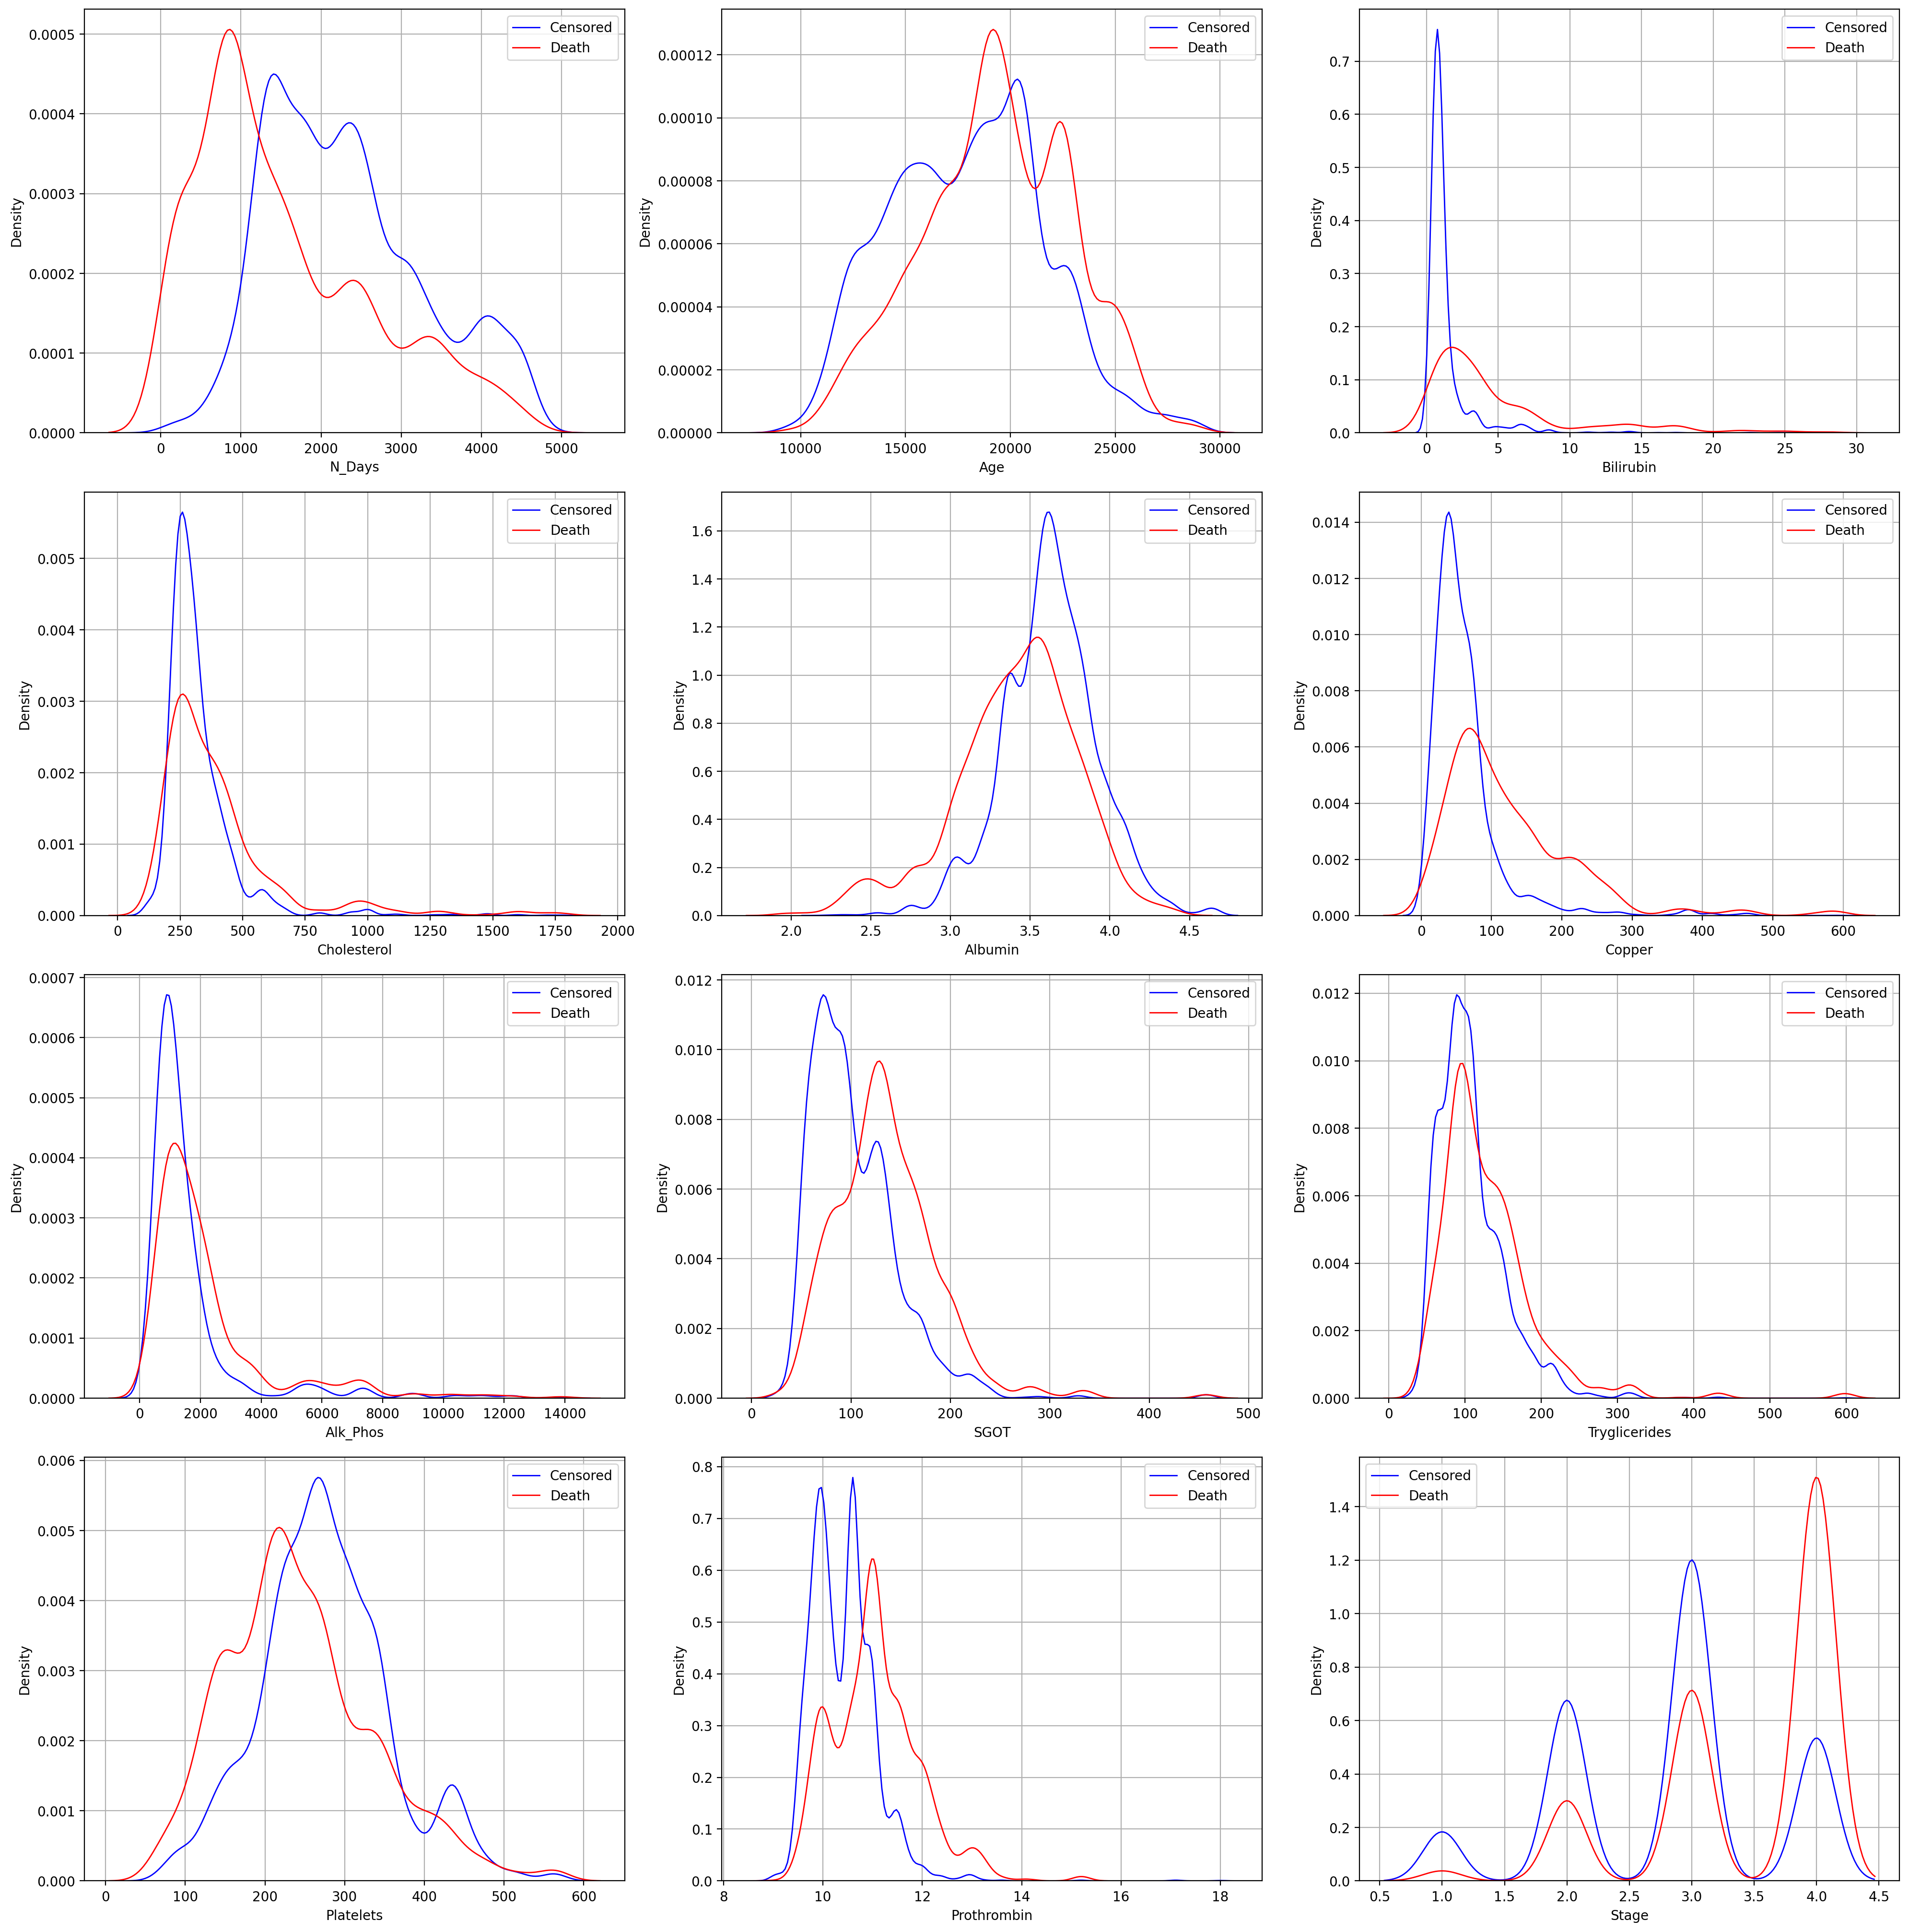

In [35]:
numeric_columns = (list(D.loc[:, train_num]))

fig = plt.figure(figsize=(20, 50))
rows, cols = 10, 3
for idx, num in enumerate(numeric_columns[:12]):
    ax = fig.add_subplot(rows, cols, idx+1)
    ax.grid(alpha = 1.0, axis ="both")
    sns.kdeplot(x = num, color ="b", linewidth=1.0, data = C, label = "Censored")
    sns.kdeplot(x = num, color ="r", linewidth=1.0, data = D, label = "Death")
    ax.set_xlabel(num)
    ax.legend()
fig.tight_layout()
fig.show()

# 5. Modeling

In [36]:
target = train_df['Status'].replace(['C', 'CL', 'D'], [0, 1, 2])
feature = train_tf
target.shape, feature.shape

((7905,), (7905, 25))

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(feature, target, random_state = 2312)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((5928, 25), (1977, 25), (5928,), (1977,))

In [38]:
from sklearn.metrics import accuracy_score, log_loss
from yellowbrick.classifier import confusion_matrix

classes = target.unique()
classes

array([2, 0, 1])

# RandomForestClassifier

rfc accuracy for train: 0.9998
rfc accuracy for val: 0.8290


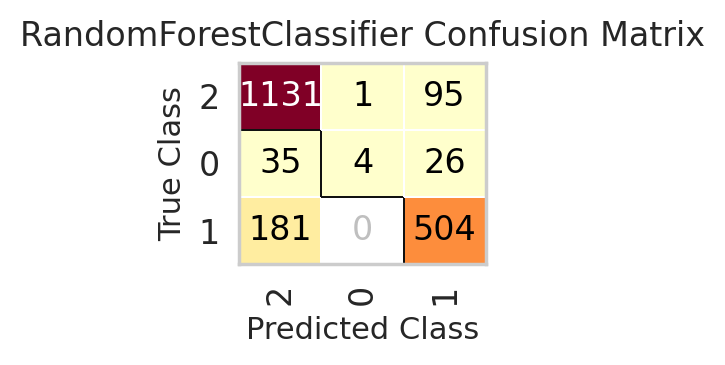

ConfusionMatrix(ax=<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=array([2, 0, 1]),
                cmap=<matplotlib.colors.ListedColormap object at 0x7bce89faf850>,
                estimator=RandomForestClassifier(random_state=2312))

In [39]:
# RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=2312)

rfc.fit(X_train, y_train)

rfc_pred_train = rfc.predict(X_train)
rfc_pred_val = rfc.predict(X_val)

print('rfc accuracy for train: {0:.4f}'.format(accuracy_score(y_train, rfc_pred_train)))
print('rfc accuracy for val: {0:.4f}'.format(accuracy_score(y_val, rfc_pred_val)))

plt.figure(figsize=(2, 2))
confusion_matrix(rfc, X_train, y_train, X_val, y_val, classes=classes)

# rfc accuracy for train: 0.9998
# rfc accuracy for val: 0.8290

In [40]:
rfc_pred = rfc.predict_proba(X_val)
print('rfc Model log_loss: {0:.4f}'.format(log_loss(y_val, rfc_pred)))

# rfc Model log_loss: 0.4820

rfc Model log_loss: 0.4820


# DecisionTreeClassifier

dtc accuracy for train: 1.0000
dtc accuracy for val: 0.7218


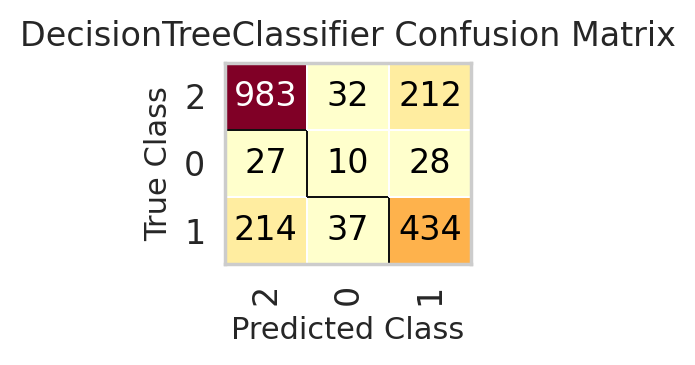

ConfusionMatrix(ax=<Axes: title={'center': 'DecisionTreeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=array([2, 0, 1]),
                cmap=<matplotlib.colors.ListedColormap object at 0x7bce840428f0>,
                estimator=DecisionTreeClassifier(random_state=2312))

In [41]:
# DecisionTreeClassifier

from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=2312)

dtc.fit(X_train, y_train)

dtc_pred_train = dtc.predict(X_train)
dtc_pred_val = dtc.predict(X_val)

print('dtc accuracy for train: {0:.4f}'.format(accuracy_score(y_train, dtc_pred_train)))
print('dtc accuracy for val: {0:.4f}'.format(accuracy_score(y_val, dtc_pred_val)))

plt.figure(figsize=(2, 2))
confusion_matrix(dtc, X_train, y_train, X_val, y_val, classes=classes)

# dtc accuracy for train: 1.0000
# dtc accuracy for val: 0.7218

In [42]:
dtc_pred = dtc.predict_proba(X_val)
print('dtc Model log_loss: {0:.4f}'.format(log_loss(y_val, dtc_pred)))

# dtc Model log_loss: 10.0273

dtc Model log_loss: 10.0273


# XGBClassifier 

xgbc accuracy for train: 0.9371
xgbc accuracy for val: 0.8366


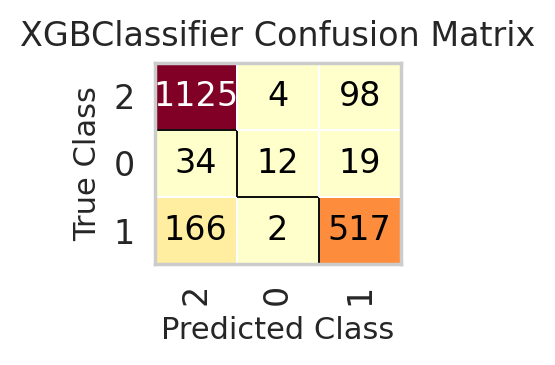

ConfusionMatrix(ax=<Axes: title={'center': 'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=array([2, 0, 1]),
                cmap=<matplotlib.colors.ListedColormap object at 0x7bce7efaf2b0>,
                estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None, device=None,
                                        e...
                                        gamma=None, grow_policy=None,
                                        importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=0.06, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        multi_strategy=None, n_estimators=10000,
                                        n_jobs=None, num_parallel_tree=None,
                                        objective='multi:softprob', ...))

In [43]:
# XGBClassifier 
from xgboost import XGBClassifier

xgbc = XGBClassifier(n_estimators=10000, learning_rate=0.06, random_state=2312)

xgbc.fit(X_train, y_train, early_stopping_rounds=100, 
         eval_set=[(X_train, y_train), (X_val, y_val)], verbose=0)

xgbc_pred_train = xgbc.predict(X_train)
xgbc_pred_val = xgbc.predict(X_val)

print('xgbc accuracy for train: {0:.4f}'.format(accuracy_score(y_train, xgbc_pred_train)))
print('xgbc accuracy for val: {0:.4f}'.format(accuracy_score(y_val, xgbc_pred_val)))

plt.figure(figsize=(2, 2))
confusion_matrix(xgbc, X_train, y_train, X_val, y_val, classes=classes)

# xgbc accuracy for train: 0.9371
# xgbc accuracy for val: 0.8366

In [44]:
xgbc_pred = xgbc.predict_proba(X_val)
print('xgbc Model log_loss: {0:.4f}'.format(log_loss(y_val, xgbc_pred)))

# xgbc Model log_loss: 0.4335

xgbc Model log_loss: 0.4335


xgbc2 accuracy for train: 0.8861
xgbc2 accuracy for val: 0.8422


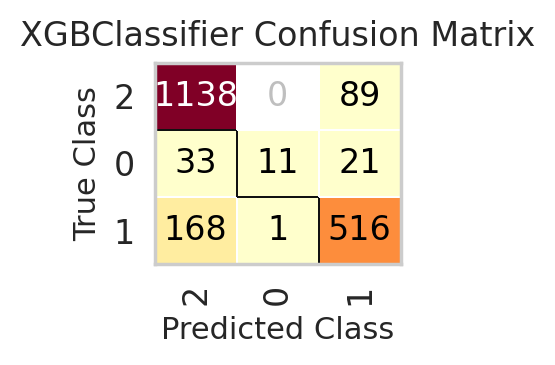

ConfusionMatrix(ax=<Axes: title={'center': 'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=array([2, 0, 1]),
                cmap=<matplotlib.colors.ListedColormap object at 0x7bce8a8a4280>,
                estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=0.1, device=None,
                                        ea...
                                        gamma=None, grow_policy=None,
                                        importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=0.01, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=6,
                                        max_leaves=None, min_child_weight=11,
                                        missing=nan, monotone_constraints=None,
                                        multi_strategy=None, n_estimators=10000,
                                        n_jobs=None, num_parallel_tree=None,
                                        objective='multi:softprob', ...))

In [45]:
# XGBoost Model with hyper-parameter

xgbc2 = XGBClassifier(n_estimators=10000, random_state=2312, learning_rate=0.01, max_depth=6, 
                             min_child_weight=11, colsample_bytree=0.1, reg_alpha=0.03)

xgbc2.fit(X_train, y_train, early_stopping_rounds=100, 
          eval_set=[(X_train, y_train), (X_val, y_val)], verbose=0)

xgbc2_pred_train = xgbc2.predict(X_train)
xgbc2_pred_val = xgbc2.predict(X_val)

print('xgbc2 accuracy for train: {0:.4f}'.format(accuracy_score(y_train, xgbc2_pred_train)))
print('xgbc2 accuracy for val: {0:.4f}'.format(accuracy_score(y_val, xgbc2_pred_val)))

plt.figure(figsize=(2, 2))
confusion_matrix(xgbc2, X_train, y_train, X_val, y_val, classes=classes)

# xgbc2 accuracy for train: 0.8861
# xgbc2 accuracy for val: 0.8422

In [46]:
xgbc2_pred = xgbc2.predict_proba(X_val)
print('xgbc2 Model log_loss: {0:.4f}'.format(log_loss(y_val, xgbc2_pred)))

# xgbc2 Model log_loss: 0.4144

xgbc2 Model log_loss: 0.4144


# LightGBM model 

lgbmc accuracy for train: 0.9202
lgbmc accuracy for val: 0.8321


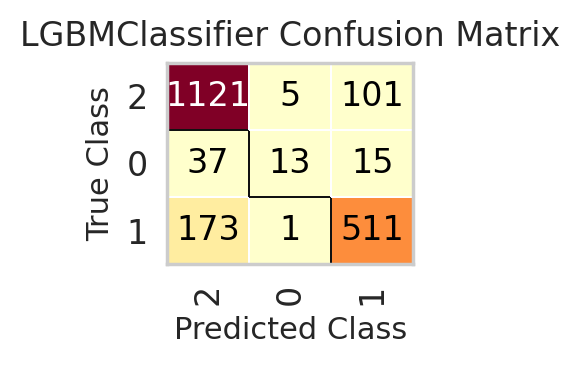

ConfusionMatrix(ax=<Axes: title={'center': 'LGBMClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=array([2, 0, 1]),
                cmap=<matplotlib.colors.ListedColormap object at 0x7bce84502140>,
                estimator=LGBMClassifier(n_estimators=200))

In [47]:
# LightGBM model 

from lightgbm import LGBMClassifier

lgbmc = LGBMClassifier(n_estimators=200)

evals = [(X_val, y_val)]
lgbmc.fit(X_train, y_train, early_stopping_rounds=100, eval_set=evals, verbose=0)

lgbmc_pred_train = lgbmc.predict(X_train)
lgbmc_pred_val = lgbmc.predict(X_val)

print('lgbmc accuracy for train: {0:.4f}'.format(accuracy_score(y_train, lgbmc_pred_train)))
print('lgbmc accuracy for val: {0:.4f}'.format(accuracy_score(y_val, lgbmc_pred_val)))

plt.figure(figsize=(2, 2))
confusion_matrix(lgbmc, X_train, y_train, X_val, y_val, classes=classes)

# lgbmc accuracy for train: 0.9202
# lgbmc accuracy for val: 0.8321

In [48]:
lgbmc_pred = lgbmc.predict_proba(X_val)
print('lgbmc Model log_loss: {0:.4f}'.format(log_loss(y_val, lgbmc_pred)))

# lgbmc Model log_loss: 0.4337

lgbmc Model log_loss: 0.4337


lgbmc2 accuracy for train: 0.8726
lgbmc2 accuracy for val: 0.8341


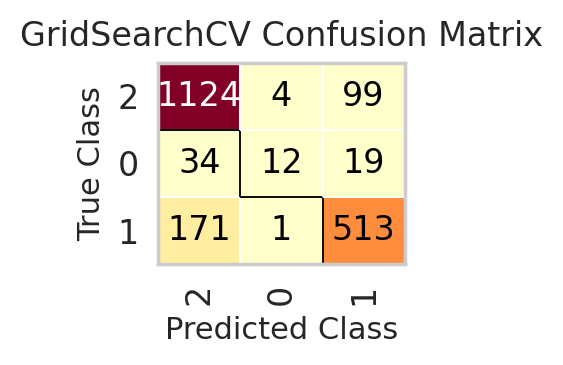

ConfusionMatrix(ax=<Axes: title={'center': 'GridSearchCV Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=array([2, 0, 1]),
                cmap=<matplotlib.colors.ListedColormap object at 0x7bce77fcbc40>,
                estimator=GridSearchCV(estimator=LGBMClassifier(n_estimators=10000),
                                       param_grid={'max_depth': [3, 6],
                                                   'min_child_samples': [14,
                                                                         16],
                                                   'num_leaves': [8, 16],
                                                   'subsample': [0.6, 0.8]}))

In [49]:
# LightGBM model with GridSearchCV

from sklearn.model_selection import GridSearchCV

lgbmc2 = LGBMClassifier(n_estimators=10000)

params = {'num_leaves': [8, 16], 'max_depth':[3, 6],
          'min_child_samples':[14, 16], 'subsample':[0.6, 0.8]}

gridcv = GridSearchCV(lgbmc2, param_grid=params)

gridcv.fit(X_train, y_train, early_stopping_rounds=30, 
           eval_set=[(X_train, y_train), (X_val, y_val)], verbose=0)

lgbmc2_pred_train = gridcv.predict(X_train)
lgbmc2_pred_val = gridcv.predict(X_val)

print('lgbmc2 accuracy for train: {0:.4f}'.format(accuracy_score(y_train, lgbmc2_pred_train)))
print('lgbmc2 accuracy for val: {0:.4f}'.format(accuracy_score(y_val, lgbmc2_pred_val)))

plt.figure(figsize=(2, 2))
confusion_matrix(gridcv, X_train, y_train, X_val, y_val, classes=classes)

# lgbmc2 accuracy for train: 0.8726
# lgbmc2 accuracy for val: 0.8341

In [50]:
lgbmc2_pred = gridcv.predict_proba(X_val)
print('lgbmc2 Model log_loss: {0:.4f}'.format(log_loss(y_val, lgbmc2_pred)))

# lgbmc2 Model log_loss: 0.4331

lgbmc2 Model log_loss: 0.4331


# catboost model 

cbc accuracy for train: 0.8806
cbc accuracy for val: 0.8346


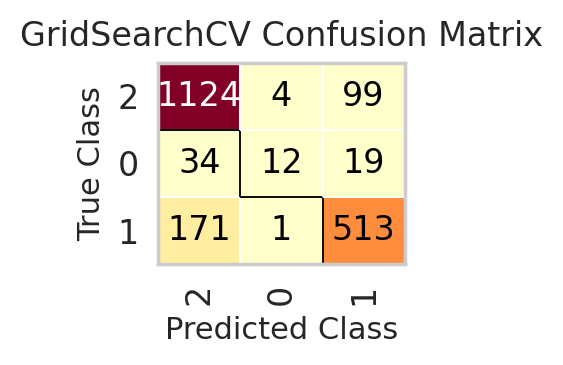

ConfusionMatrix(ax=<Axes: title={'center': 'GridSearchCV Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=array([2, 0, 1]),
                cmap=<matplotlib.colors.ListedColormap object at 0x7bce77fcba00>,
                estimator=GridSearchCV(estimator=LGBMClassifier(n_estimators=10000),
                                       param_grid={'max_depth': [3, 6],
                                                   'min_child_samples': [14,
                                                                         16],
                                                   'num_leaves': [8, 16],
                                                   'subsample': [0.6, 0.8]}))

In [51]:
# catboost model 

from catboost import CatBoostClassifier

cbc = CatBoostClassifier(n_estimators=10000, learning_rate = 0.06, random_state=2312, verbose=0)
cbc.fit(X_train, y_train, early_stopping_rounds=100, 
        eval_set=[(X_train, y_train), (X_val, y_val)], verbose=0)

cbc_pred_train = cbc.predict(X_train)
cbc_pred_val = np.concatenate(cbc.predict(X_val))

print('cbc accuracy for train: {0:.4f}'.format(accuracy_score(y_train, cbc_pred_train)))
print('cbc accuracy for val: {0:.4f}'.format(accuracy_score(y_val, cbc_pred_val)))

plt.figure(figsize=(2, 2))
confusion_matrix(gridcv, X_train, y_train, X_val, y_val, classes=classes)

# cbc accuracy for train: 0.8806
# cbc accuracy for val: 0.8346

In [52]:
cbc_pred = cbc.predict_proba(X_val)
print('cbc Model log_loss: {0:.4f}'.format(log_loss(y_val, cbc_pred)))

# cbc Model log_loss: 0.4335

cbc Model log_loss: 0.4335


# 6. Weighted Model Blending

In [53]:
wmb_pred = (0.92*xgbc2.predict_proba(X_val) + 
            0.04*gridcv.predict_proba(X_val) + 
            0.02*lgbmc.predict_proba(X_val) + 
            0.01*cbc.predict_proba(X_val) + 
            0.01*xgbc.predict_proba(X_val))
wmb_pred
print('wmb Model log_loss: {0:.4f}'.format(log_loss(y_val, wmb_pred)))
# wmb Model log_loss: 0.4137

wmb Model log_loss: 0.4137


# 7. submission

In [54]:
print(test_tf.shape)
test_tf.head(2)

(5271, 25)


,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y
0,1.508158,0.388355,-0.086678,1.380682,-0.580392,0.061686,0.452329,0.89581,-0.382381,1.755820,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,0.483461,-0.917739,-0.205571,1.701809,2.200202,0.538268,0.045511,0.89581,0.974303,-0.380957,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [55]:
wmb_pred = (0.92*xgbc2.predict_proba(test_tf) + 
            0.04*gridcv.predict_proba(test_tf) + 
            0.02*lgbmc.predict_proba(test_tf) + 
            0.01*cbc.predict_proba(test_tf) + 
            0.01*xgbc.predict_proba(test_tf))
wmb_pred[:5]

array([[0.49127817, 0.02642131, 0.48230056],
       [0.51898185, 0.2453343 , 0.23568385],
       [0.03700156, 0.03003942, 0.93295907],
       [0.96315351, 0.00615877, 0.03068777],
       [0.82688048, 0.07545944, 0.09766011]])

In [56]:
submission = pd.DataFrame(wmb_pred, columns=['Status_C', 'Status_CL', 'Status_D'])
submission.insert(0, 'id', test_df['id'])
submission.head()

,id,Status_C,Status_CL,Status_D
0,7905,0.491278,0.026421,0.482301
1,7906,0.518982,0.245334,0.235684
2,7907,0.037002,0.030039,0.932959
3,7908,0.963154,0.006159,0.030688
4,7909,0.826880,0.075459,0.097660


In [57]:
submission.to_csv('submission.csv', index=False)

-